In [22]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
import flax
import pickle
from jaxtyping import ArrayLike
from collections import defaultdict
import inspect
import matplotlib.pyplot as plt
from tracr.rasp import rasp
from tracr.compiler import compiling, rasp_to_graph
import numpy as np
from tracr.compiler.validating import validate
from rasp_generator import map_primitives, sampling, utils
import networkx as nx

from tracr.rasp.rasp import Map, SequenceMap, LinearSequenceMap, Select, Aggregate, Comparison, SelectorWidth, indices, tokens 

rng = np.random.default_rng()

def compile_rasp_to_model(sop: rasp.SOp, vocab={1,2,3,4}, max_seq_len=5, compiler_bos="BOS"):
    return compiling.compile_rasp_to_model(
        sop,
        vocab=vocab,
        max_seq_len=max_seq_len,
        compiler_bos=compiler_bos,
    )


### Stats

In [14]:
def sample_test_input(rng, vocab={0,1,2,3,4}, max_seq_len=5):
    seq_len = rng.choice(range(1, max_seq_len+1))
    return rng.choice(list(vocab), size=seq_len).tolist()


def is_constant(program: rasp.SOp, test_inputs):
    reference = program(test_inputs[0])
    for x in test_inputs:
        if program(x) != reference:
            return False
    return True

const_test_inputs = [sample_test_input(rng) for _ in range(5)]

In [16]:
def program_statistics(program: rasp.SOp):
    graph = rasp_to_graph.extract_rasp_graph(program).graph
    sorted_labels = list(nx.topological_sort(graph))
    length = len(sorted_labels)

    program_stats = defaultdict(int)
    for label in sorted_labels:
        expr = graph.nodes[label]["EXPR"]
        sop_class = type(expr).__name__
        if sop_class == "Select":
            continue

        sop_type = expr.annotations["type"]  # TODO
        if sop_class in {"Map", "Aggregate"}:
            sop_class = f"{sop_class}_{sop_type}"

        program_stats[sop_class] += 1

    
    return program_stats, length, is_constant(program, const_test_inputs)

In [18]:
total_stats = defaultdict(int)
count = 0
lengths = []
iscons = []
for _ in range(1000):
    sampler = sampling.ProgramSampler(validate_compilation=False)
    errs = sampler.sample(n_sops=30)
    program_stats, program_length, iscon = program_statistics(sampler.program)
    lengths.append(program_length)
    iscons.append(iscon)
    for k, v in program_stats.items():
        total_stats[k] += v
    count += 1

In [20]:
np.mean(iscons)

0.0

<BarContainer object of 10 artists>

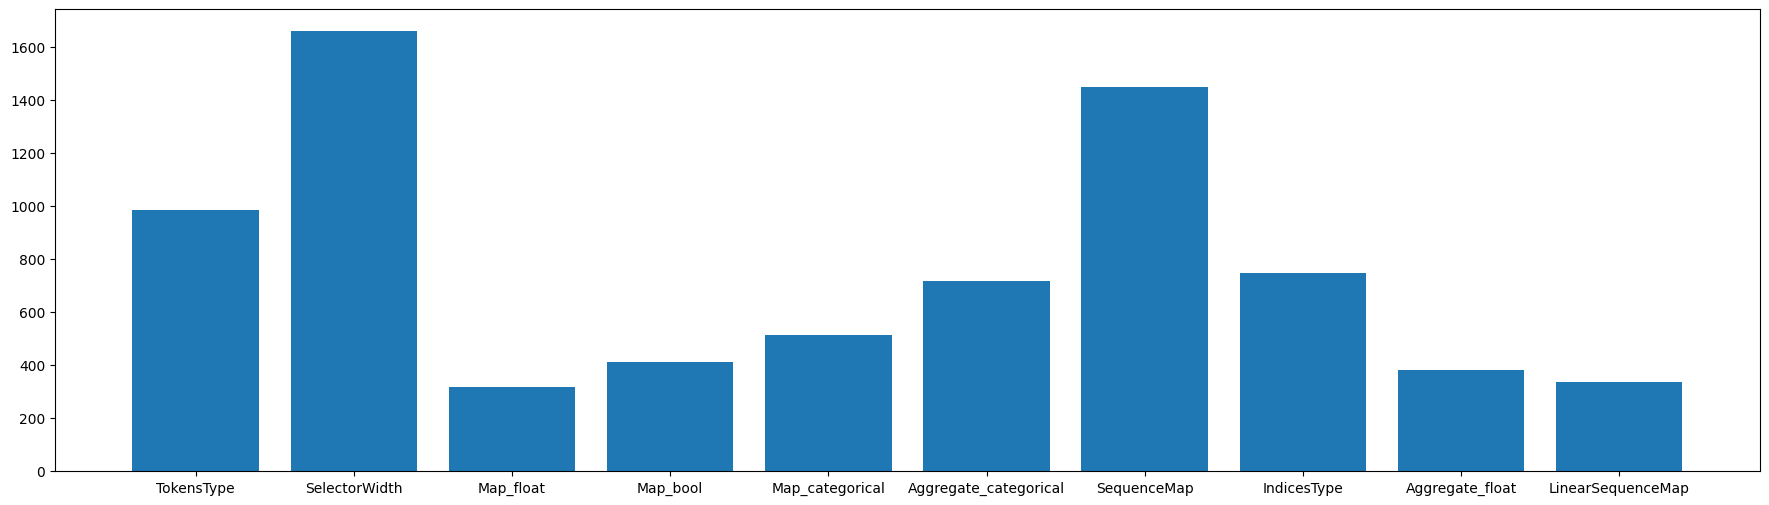

In [23]:
plt.figure(figsize=(22,6))
plt.bar(total_stats.keys(), total_stats.values())

In [24]:
np.mean(lengths), np.std(lengths)

(10.268, 4.846047461591766)

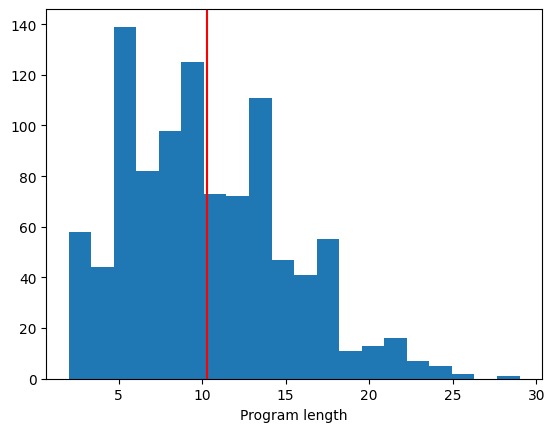

In [25]:
plt.hist(lengths, bins=20)
plt.xlabel("Program length")
plt.axvline(np.mean(lengths), color="red", label="Mean")